# Lab | Making predictions with logistic regression

In this lab, you will be using the Sakila database of movie rentals.

In order to optimize our inventory, we would like to know which films will be rented next month and we are asked to create a model to predict it.

**Instructions**
1. Create a query or queries to extract the information you think may be relevant for building the prediction model. It should include some film features and some rental features. Use the data from 2005.
2. Create a query to get the list of films and a boolean indicating if it was rented last month (August 2005). This would be our target variable.
3. Read the data into a Pandas dataframe.
4. Analyze extracted features and transform them. You may need to encode some categorical variables, or scale numerical variables.
5. Create a logistic regression model to predict this variable from the cleaned data.
6. Evaluate the results.

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import neighbors
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import pymysql
from sqlalchemy import create_engine
import getpass  # To get the password without showing the input
password = getpass.getpass()

 ··············


## 1,2,3: SQL and Import into Dataframe

In [7]:
connection_string = 'mysql+pymysql://root:' + password + '@localhost/bank'
engine = create_engine(connection_string)

sql = '''
select erin_is_awesome.title, erin_is_awesome.category, coalesce(appearances,0) as appearances, may, june, july, case when august > 0 then 1 else 0 end as august 
from(
	select f.title, f.film_id, c.name as category
	, count(case when month(rental_date)=5 then 1 else null end) as may
	, count(case when month(rental_date)=6 then 1 else null end) as june
	, count(case when month(rental_date)=7 then 1 else null end) as july
	, count(case when month(rental_date)=8 then 1 else null end) as august
	from sakila.film f
	inner join sakila.film_category fc on fc.film_id = f.film_id
	inner join sakila.category c on c.category_id = fc.category_id
	left join sakila.inventory i on i.film_id = f.film_id
	left join sakila.rental r on i.inventory_id = r.inventory_id
	group by 1,2,3
) erin_is_awesome
	left join (
		select x.film_id, x.actor_id, f.title, a.first_name, a.last_name, appearances from
		(
		  select fa.film_id, fa.actor_id, appearances, row_number() over (partition by fa.film_id order by appearances desc) as row_num
		  from sakila.film_actor fa
		  inner join (
				select fa.actor_id, count(*) as appearances
				from sakila.film_actor fa
				group by fa.actor_id
				order by appearances desc
				) ap on ap.actor_id = fa.actor_id
		) x
		inner join sakila.actor a on x.actor_id = a.actor_id
		inner join sakila.film f on x.film_id = f.film_id
		where x.row_num = 1) actor on actor.film_id = erin_is_awesome.film_id
'''

In [8]:
# fd = film_date
fd = pd.read_sql_query(sql, engine)
display(fd.head())
display(fd.shape)
display(fd.dtypes)
display(fd.isna().sum())

,title,category,appearances,may,june,july,august
0,AMADEUS HOLY,Action,35,1,4,8,1
1,AMERICAN CIRCUS,Action,34,2,3,8,1
2,ANTITRUST TOMATOES,Action,35,2,2,4,1
3,ARK RIDGEMONT,Action,27,0,0,0,0
4,BAREFOOT MANCHURIAN,Action,32,1,3,8,1


(1000, 7)

title          object
category       object
appearances     int64
may             int64
june            int64
july            int64
august          int64
dtype: object

title          0
category       0
appearances    0
may            0
june           0
july           0
august         0
dtype: int64

## Function Definitions

In [9]:
#got none, yet

## 4: Analyze extracted features and transform them. 

### Exploring and checks

Looking into the film categories we have...


Sports         74
Foreign        73
Family         69
Documentary    68
Animation      66
Action         64
New            63
Drama          62
Games          61
Sci-Fi         61
Children       60
Comedy         58
Classics       57
Travel         57
Horror         56
Music          51
Name: category, dtype: int64


Checking mutlicorelinationaryables


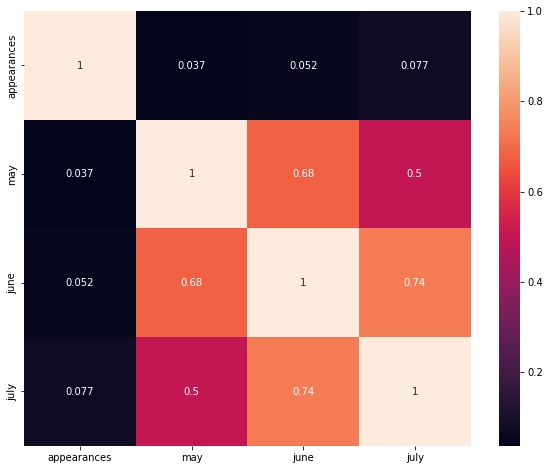

(1000, 7)

In [10]:
# how many film categories are there?  ...16 - poss too many, lets try it though and then perhaps try reducing them into lower categories, there is a similar spread of titles between them and I have a sneak feeling there are pretty randomly distributed so might be best to drop altogether.
print('Looking into the film categories we have...')
display(fd.category.value_counts())


print()
print('Checking mutlicorelinationaryables')
corr_matrix=fd.drop('august', axis=1).corr(method='pearson')  # default
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

fd.shape

### Model stuff

In [11]:
y = fd['august']
X = fd.drop('august', axis=1)

#X_train, X_test, y_train, y_test = train_test_split(
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1337)


X_train_num = X_train.select_dtypes(include = np.number)

# Scaling data
transformer = MinMaxScaler().fit(X_train_num)
X_train_normalized = transformer.transform(X_train_num)
X_train_norm = pd.DataFrame(X_train_normalized)

X_train_norm.columns = ['appearances','may','june','july']

# # Plot some things
# sns.displot(X_train_norm['appearances'])
# plt.show()

# sns.displot(X_train_norm['may'])
# plt.show()

# sns.displot(X_train_norm['june'])
# plt.show()

# sns.displot(X_train_norm['july'])
# plt.show()


# Encoding
X_train_categorical = X_train.select_dtypes(include = object)
X_train_categorical = X_train_categorical.drop(['title'],axis=1)
X_train_cat = pd.get_dummies(X_train_categorical, columns=['category'], drop_first=True)
X_train_cat.head()

,category_Animation,category_Children,category_Classics,category_Comedy,category_Documentary,category_Drama,category_Family,category_Foreign,category_Games,category_Horror,category_Music,category_New,category_Sci-Fi,category_Sports,category_Travel
46,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
789,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
722,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
283,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
39,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [13]:
y.sum() # we have a highly imblanced target... 958 / 1000

958

In [14]:
X_train_transformed = np.concatenate((X_train_norm, X_train_cat), axis=1)

classification = LogisticRegression(random_state=0, solver='lbfgs',
                   multi_class='multinomial').fit(X_train_transformed, y_train)


X_test_num = X_test.select_dtypes(np.number)

X_test_normalized = transformer.transform(X_test_num)
X_test_norm = pd.DataFrame(X_test_normalized)

X_test_categorical = X_test.select_dtypes(object)
X_test_categorical = X_test_categorical.drop(['title'],axis=1)
X_test_cat = pd.get_dummies(X_test_categorical, columns=['category'], drop_first=True)

display(list(zip(list(X_train_cat.columns), list(X_test_cat.columns))))
X_test_cat.head()

[('category_Animation', 'category_Animation'),
 ('category_Children', 'category_Children'),
 ('category_Classics', 'category_Classics'),
 ('category_Comedy', 'category_Comedy'),
 ('category_Documentary', 'category_Documentary'),
 ('category_Drama', 'category_Drama'),
 ('category_Family', 'category_Family'),
 ('category_Foreign', 'category_Foreign'),
 ('category_Games', 'category_Games'),
 ('category_Horror', 'category_Horror'),
 ('category_Music', 'category_Music'),
 ('category_New', 'category_New'),
 ('category_Sci-Fi', 'category_Sci-Fi'),
 ('category_Sports', 'category_Sports'),
 ('category_Travel', 'category_Travel')]

,category_Animation,category_Children,category_Classics,category_Comedy,category_Documentary,category_Drama,category_Family,category_Foreign,category_Games,category_Horror,category_Music,category_New,category_Sci-Fi,category_Sports,category_Travel
977,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
56,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
801,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
747,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [15]:
X_test_transformed = np.concatenate([X_test_norm, X_test_cat],axis=1)
wtf_do_i_have_here = pd.DataFrame(X_test_transformed)
wtf_do_i_have_here

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,0.928571,0.4,0.714286,0.933333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.761905,0.2,0.142857,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.833333,0.6,0.857143,0.800000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.761905,0.2,0.285714,0.400000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.833333,0.0,0.142857,0.200000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.738095,0.0,0.428571,0.400000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
196,0.833333,0.6,0.571429,0.733333,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
197,0.761905,0.0,0.142857,0.200000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
198,0.785714,0.0,0.142857,0.200000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [16]:
predictions = classification.predict(X_test_transformed)
classification.score(X_test_transformed, y_test)

0.955

In [17]:
confusion_matrix(y_test, predictions)

array([[  1,   9],
       [  0, 190]], dtype=int64)

### *Due to the imbalance (almost always rented in August are model tends to putting in a few too many positives)*

## Everybody loves good neighboUrs

In [18]:
clf = neighbors.KNeighborsClassifier(n_neighbors=2, weights='uniform')
clf.fit(X_train_transformed, y_train)
predictions_clf = clf.predict(X_test_transformed)
clf.score(X_test_transformed, y_test)

0.995

In [19]:
confusion_matrix(y_test, predictions_clf)

array([[  9,   1],
       [  0, 190]], dtype=int64)

### *With some tweaking of the number of neighbours we get a near perfect prediction*

In [31]:
not_rented_before = fd[(fd['may']==0) & (fd['june']==0) & (fd['july']==0)]['title']
not_rented_in_august = fd[(fd['august']==0)]['title']

display(list(zip(list(not_rented_before), list(not_rented_in_august))))

# So the films that were not watched before are same as ones not watched in august...hence the high prediction and including appearances/category is likely what is throwing it off but only due to the fake db...

# ...also, the real question is how come nobody watched Sister Freddy or Chocholate Duck?

[('ARK RIDGEMONT', 'ARK RIDGEMONT'),
 ('FIREHOUSE VIETNAM', 'FIREHOUSE VIETNAM'),
 ('SKY MIRACLE', 'SKY MIRACLE'),
 ('ARGONAUTS TOWN', 'ARGONAUTS TOWN'),
 ('FLOATS GARDEN', 'FLOATS GARDEN'),
 ('SISTER FREDDY', 'SISTER FREDDY'),
 ('WALLS ARTIST', 'WALLS ARTIST'),
 ('ALICE FANTASIA', 'ALICE FANTASIA'),
 ('TADPOLE PARK', 'TADPOLE PARK'),
 ('VOLUME HOUSE', 'VOLUME HOUSE'),
 ('FRANKENSTEIN STRANGER', 'FRANKENSTEIN STRANGER'),
 ('HATE HANDICAP', 'HATE HANDICAP'),
 ('DELIVERANCE MULHOLLAND', 'DELIVERANCE MULHOLLAND'),
 ('KILL BROTHERHOOD', 'KILL BROTHERHOOD'),
 ('RAIDERS ANTITRUST', 'RAIDERS ANTITRUST'),
 ('RAINBOW SHOCK', 'RAINBOW SHOCK'),
 ('VILLAIN DESPERATE', 'VILLAIN DESPERATE'),
 ('APOLLO TEEN', 'APOLLO TEEN'),
 ('GLADIATOR WESTWARD', 'GLADIATOR WESTWARD'),
 ('HOCUS FRIDA', 'HOCUS FRIDA'),
 ('CATCH AMISTAD', 'CATCH AMISTAD'),
 ('CHOCOLATE DUCK', 'CHOCOLATE DUCK'),
 ('CROSSING DIVORCE', 'CROSSING DIVORCE'),
 ('CRYSTAL BREAKING', 'CRYSTAL BREAKING'),
 ('MUPPET MILE', 'MUPPET MILE'),
 ('PE